# **1번**

In [1]:
# sklearn 패키지에서 tree를 import 
from sklearn import tree

- 모듈 불러오기

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

In [3]:
import pydot
from IPython.core.display import Image 

- 데이터 로드

In [4]:
from sklearn.datasets import load_wine 
X, y = load_wine(return_X_y=True)
wine = load_wine()

In [5]:
feature_names = load_wine().feature_names
class_names = load_wine().target_names

In [6]:
print(load_wine().feature_names) # 독립변수 13개
print(load_wine().target_names) # 종속변수 3개의 class 

['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
['class_0' 'class_1' 'class_2']


- 트리의 시각화

In [7]:
# 함수로 만듦.
def draw_decision_tree(clf, feature_names = None, class_names = None):
    dot_data = export_graphviz(clf, out_file = None, 
                                feature_names = feature_names,
                                class_names = class_names,
                                filled = True, 
                                rounded = True,
                                special_characters = True)
    graph = pydot.graph_from_dot_data(dot_data)[0]
    image = graph.create_png()
    return Image(image)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

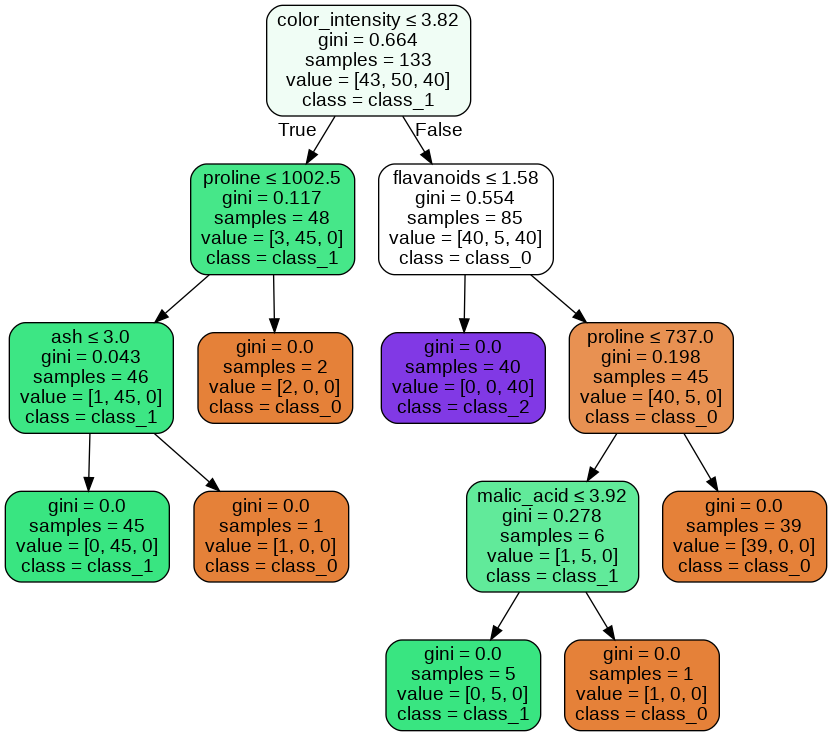

In [21]:
# Pruning 되기 전 
clf_1 = DecisionTreeClassifier(random_state=0)
tree_nottuned = clf_1.fit(X_train, y_train)
draw_decision_tree(tree_nottuned, feature_names, class_names)

* Grid Search

In [10]:
from sklearn.model_selection import GridSearchCV # 관심 있는 매개변수들을 대상으로 가능한 모든 조합을 시도하여 최적의 매개변수를 찾는 방법

hyperparamters = {'max_depth': list(range(2, 8)),  'min_samples_split': list(range(2, 20))}
GridCV = GridSearchCV(estimator=tree_nottuned, param_grid=hyperparamters, cv=5, verbose=1) 
GridCV.fit(X_train, y_train)
GridCV.best_params_ # 가장 좋은 성능을 보였을 때의 parameter

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:    0.8s finished


{'max_depth': 3, 'min_samples_split': 2}

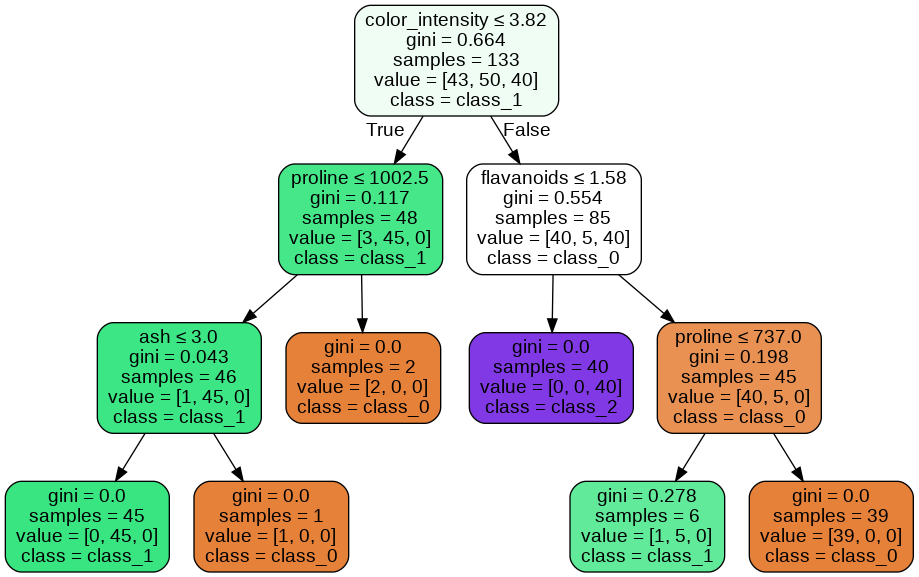

In [11]:
clf = DecisionTreeClassifier(random_state=0, max_depth = 3, min_samples_split = 2)
tree_tuned = clf.fit(X_train, y_train)
draw_decision_tree(tree_tuned, feature_names, class_names)

* Cost Complexity Pruning

In [12]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.22.2.post1.


In [13]:
clf = DecisionTreeClassifier(random_state=0)

path = clf.cost_complexity_pruning_path(X_train, y_train)

# alphas, inpurities
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Number of nodes in the 1th tree is: 13 with ccp_alpha: 0.0


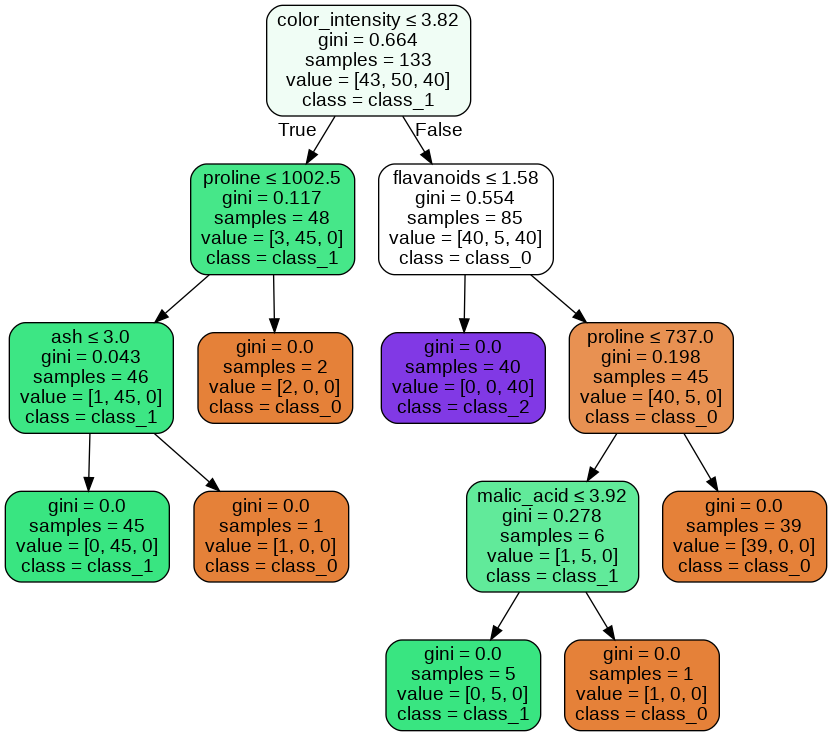

Number of nodes in the 2th tree is: 11 with ccp_alpha: 0.012531328320802006


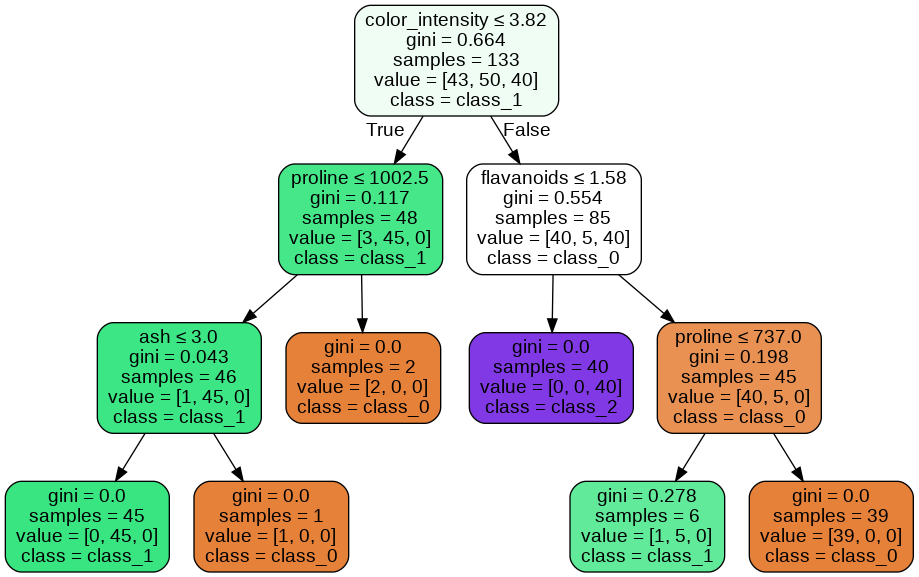

Number of nodes in the 3th tree is: 9 with ccp_alpha: 0.014710689767897992


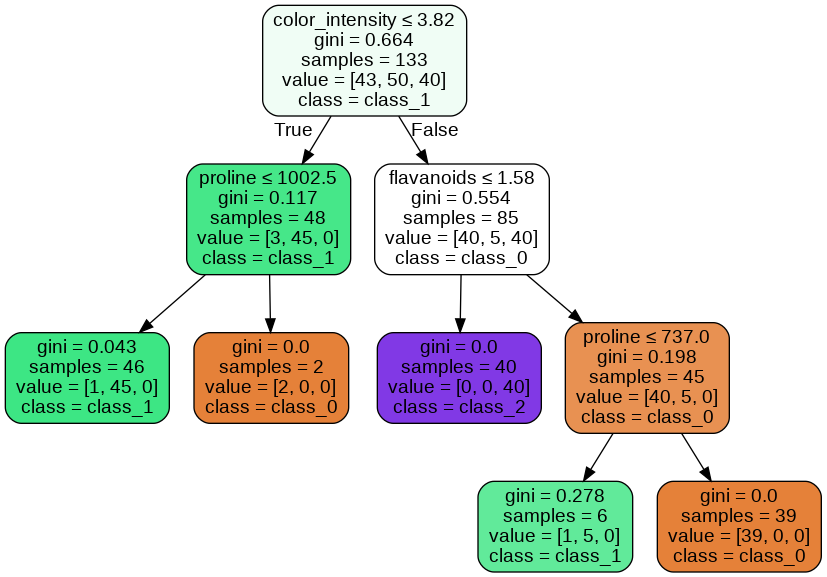

Number of nodes in the 4th tree is: 7 with ccp_alpha: 0.02758254331480877


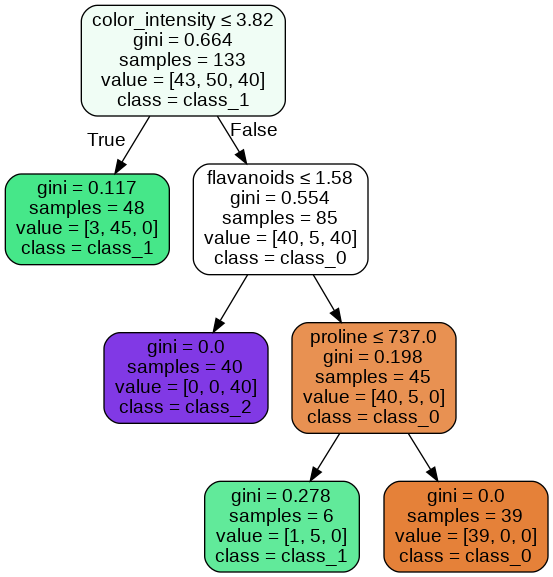

Number of nodes in the 5th tree is: 5 with ccp_alpha: 0.05430242272347535


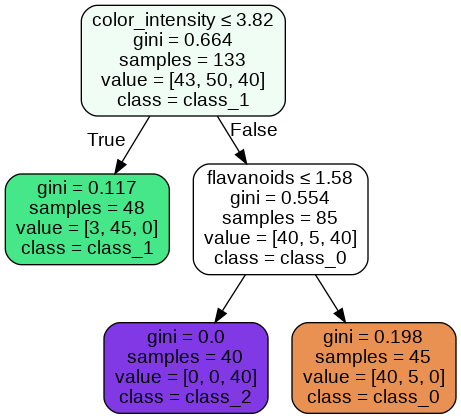

Number of nodes in the 6th tree is: 1 with ccp_alpha: 0.2772811571535354


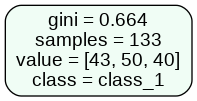

In [14]:
clfs = []
count = 0
for ccp_alpha in ccp_alphas:
    # 각 effective alphas 이용해 decision tree 만들기
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf = clf.fit(X_train, y_train)
    count += 1
    print("Number of nodes in the {}th tree is: {} with ccp_alpha: {}".format(
      count, clf.tree_.node_count, ccp_alpha))
    display(draw_decision_tree(clf, feature_names, class_names))
    clfs.append(clf)
    print("====================================================================================")

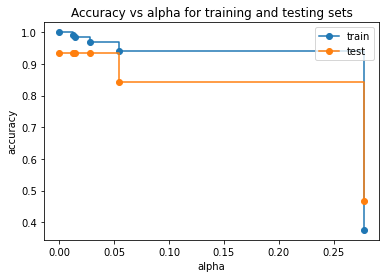

Decision tree without pruning : 13 nodes, 0.933 accuracy
Decision tree with the best pruning : 13 nodes, 0.933 accuracy


In [15]:
# testing accuracy를 높이는 최고의 ccp_alpha는?
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

print("Decision tree without pruning : {0} nodes, {1:.3} accuracy".format(tree_nottuned.tree_.node_count, tree_nottuned.score(X_test, y_test)))
print("Decision tree with the best pruning : {0} nodes, {1:.3} accuracy".format(clfs[test_scores.index(max(test_scores))].tree_.node_count, max(test_scores)))

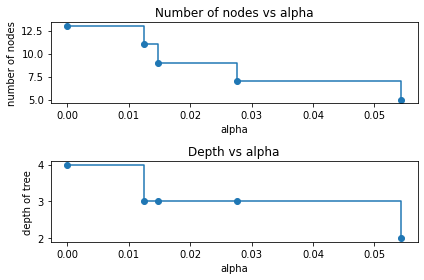

In [16]:

# 노드가 하나뿐인 마지막 tree는 제외
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

# tree의 node 수
node_counts = [clf.tree_.node_count for clf in clfs]
# tree의 depth
depth = [clf.tree_.max_depth for clf in clfs]

fig, ax = plt.subplots(2, 1)
# Number of nodes vs alpha
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
# Depth vs alpha
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

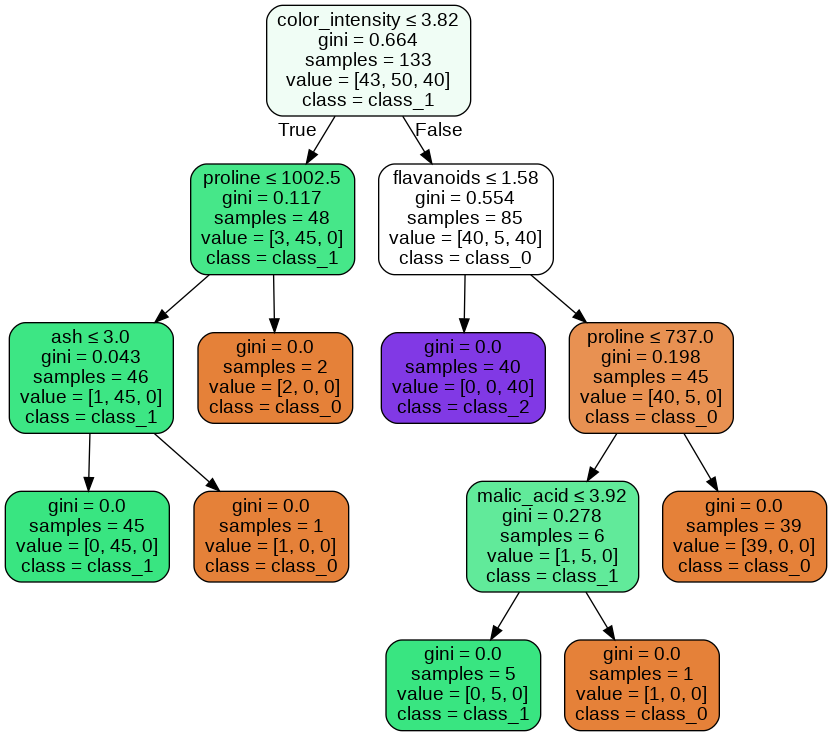

In [17]:
# testing accuracy를 높이는 최고의 ccp_alpha
clf = DecisionTreeClassifier(random_state=0, ccp_alpha=0.01)
clf = clf.fit(X_train, y_train)
draw_decision_tree(clf, feature_names, class_names)

* tuning 유무에 따른 accuracy 비교

In [22]:
# tree_tuned = DecisionTreeClassifier(max_depth=3, min_samples_split=2, random_state=0)
from sklearn.model_selection import cross_validate
import numpy as np
tree_tuned_scores = cross_validate(clf, X_train, y_train, scoring='accuracy', cv=5, return_train_score = False)
tree_scores = cross_validate(clf_1, X_train, y_train, scoring='accuracy', cv=5, return_train_score = False)
print(tree_tuned_scores)
print("Tree parameter tuned (X) - Accuracy : {:.3f}".format(np.mean(tree_scores['test_score'])))
print("Tree parameter tuned (O) - Accuracy : {:.3f}".format(np.mean(tree_tuned_scores['test_score'])))  ## 데이터 수가 적어서, accuracy의 차이는 없음.

{'fit_time': array([0.00466609, 0.00102663, 0.00094652, 0.00098634, 0.00086403]), 'score_time': array([0.0004003 , 0.00029755, 0.00023651, 0.0002563 , 0.00024891]), 'test_score': array([0.88888889, 0.96296296, 0.92592593, 0.88461538, 0.80769231])}
Tree parameter tuned (X) - Accuracy : 0.894
Tree parameter tuned (O) - Accuracy : 0.894


# **2번**

Decision tree는 종속변수가 범주형 변수이면 '분류 트리', 연속형 변수이면 '회귀 트리'로 구분된다. 트리를 가지치기하기 위해서는 기준이 되는 독립변수와 경계값을 설정해야 한다. 이때, 불순도가 가장 낮아지는(=엔트로피가 낮아지는 = Information Gain이 높아지는) 방향으로 트리를 나눈다. 하지만, Full tree와 같이 너무 자세하게 구분된 tree는 오비피팅 문제가 발생할 수 있으며, pruing을 통해 이러한 문제를 해결한다.